In [48]:
# Import Optimization Libraries
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# Import General Libraries
import sympy as sym
import numpy as np
from IPython.display import display 

# Create a Concrete Model
model = ConcreteModel()

In [49]:
Nodes = 100
model.Nodes = range(0,Nodes)

In [50]:
model.X0 = Param(initialize = 0.0) # position of fixed base
model.Y0 = Param(initialize = 0.0)
model.h = Param(initialize = 0.02) # time step

model.Damping = Param(initialize = 0.7)  # Damping coefficient
model.mass = Param(initialize = 1.0) # mass of the 'mass'

# Initailize Position, Velocity and Acceleration
model.x1 = Var(model.Nodes)
model.dx1 = Var(model.Nodes)
model.ddx1 = Var(model.Nodes)

model.Force = Var(model.Nodes)

# Define Contact Force
model.CF_ext = Var(model.Nodes)
model.CF_rtn = Var(model.Nodes)
model.L_max = Param(initialize = 4)
model.L_min = Param(initialize = 0)

In [51]:
# Intergration Constraints
def BwEuler_p(model,n): # Positions
    if n > 1:
        return model.x1[n] == model.x1[n-1] + model.h*model.dx1[n-1]
    else:
        return Constraint.Skip # Leaves out members of a set that the constraint doesn't apply to
model.integrate_p = Constraint(model.Nodes, rule = BwEuler_p)

def BwEuler_v(model,n): # Velocities
    if n > 1:
        return model.dx1[n] == model.dx1[n-1] + model.h*model.ddx1[n-1]
    else:
        return Constraint.Skip 
model.integrate_v = Constraint(model.Nodes, rule = BwEuler_v)

In [52]:
X0 = sym.symbols('X0')   #starting position of the block
m1 = sym.symbols('m1')   #mass of the block
b1 = sym.symbols('b1')   #damping coefficient

L_max = sym.symbols('L_max')  # Max stroke length
L_min = sym.symbols('L_min')  # Min stroke length

x1 = sym.symbols('x1')                #position of the block
dx1 = sym.symbols('\dot{\\ x}_{1}')    #velocity of the block
ddx1 = sym.symbols('\ddot{\\ x}_{1}')  #acceleration of the block

q = sym.Matrix([x1])
dq = sym.Matrix([dx1])
ddq = sym.Matrix([ddx1])

Xnew = X0 + x1

p1 = sym.Matrix([Xnew, x1])
[dXnew, dx1] = p1.jacobian(q)*dq
#display(p1)             # [original position + current position ; current position]

# Just checking
dp1 = sym.Matrix([dXnew, dx1]) # --> derivative of the p1 matrix
#display(dp1)

######################################################################################################################
######################################################################################################################

#Define kinetic and potential energies for use in Lagrangian
T = sym.Matrix([0.5*m1*(dXnew**2)])
V = sym.Matrix([0]) 

# Define damping
Damp = sym.Matrix([b1*dx1])
#display(Damp)

#Calculate terms of the Lagrangian Equation
Lg1 = sym.zeros(1,len(q))
for i in range(len(q)):
    dT_ddq = sym.diff(T,dq[i]) 
    Lg1[i] = dT_ddq.jacobian(q)*dq + dT_ddq.jacobian(dq)*ddq 

Lg3 = T.jacobian(q)

Lg4 = V.jacobian(q) 

#apply a horizontal force
F = sym.symbols('F')                  #applied force parameter
FF = sym.Matrix([[F],[0],[0]])        #force matrix
rF = sym.Matrix([[X0 + Xnew],[0],[0]])  #distance the force acts on the block
JF = rF.jacobian(q)
QF = JF.transpose()*FF
#display(QF)
Force = QF

# Complimentarity Forces
F_ext = sym.symbols('F_ext')
Extention = sym.Matrix([F_ext])
F_rtn = sym.symbols('F_rtn')
Retraction = sym.Matrix([F_rtn])

#Equation of motion
EOM = Lg1 - Lg3 + Lg4 - Damp - Force.transpose() + Retraction - Extention
display(EOM)

Matrix([[-F - F_ext + F_rtn + 1.0*\ddot{ x}_{1}*m1 - \dot{ x}_{1}*b1]])

In [53]:
# Lambdify the EOM
func_map = {'sin':sin, 'cos':cos}  
sym_list = [X0, x1, dx1, ddx1, F, m1, b1, F_ext, F_rtn]

lambEOM1 = sym.lambdify(sym_list, EOM[0], modules = [func_map])

#display(lambEOM1)

# Create EOM Constraints
def EOM1(model,n): 
    # list the model versions of all quantities in the same order as sym_list
    var_list = [model.X0, model.x1[n], model.dx1[n], model.ddx1[n], model.Force[n], model.mass, model.Damping, model.CF_ext[n], 
               model.CF_rtn[n]] 
    return lambEOM1(*var_list) == 0
model.EOM = Constraint(model.Nodes, rule = EOM1)

In [54]:
# Define Complimentarity Constraints

# Constraint Functions -->> applies a contact force when the maximum stroke length of the piston is reached, cylinder extended
                        # from rest to max displacement

# Set Epsilon 
eps = 1000

# Extention    
def extention_contact(model,n):
    for n in range(1, Nodes):
        alpha_ext = model.L_max - model.x1[n-1]
        if n < Nodes:
            return alpha_ext*model.CF_ext[n] <= eps
        else:
            return Constraint.Skip
model.extention_contact = Constraint(model.Nodes, rule = extention_contact)

########################################################################################################################

# Retraction 
def retraction_contact(model,n):
    for n in range(1,Nodes):
        alpha_rtn = model.x1[n-1] - model.L_min
        if n < Nodes:
            return alpha_rtn*model.CF_rtn[n] <= eps
        else:
            return Constraint.Skip
model.retraction_contact = Constraint(model.Nodes, rule = retraction_contact)    

In [55]:
# Define Cost Function
def CostFunction(model):
    sum_force = 0
    for n in range(1,Nodes):
            sum_force = sum_force + model.Force[n]**2 
    return sum_force

model.Cost = Objective(rule = CostFunction)

In [56]:
# Define Variable Bounds
for n in range(1,Nodes):
    model.Force[n].setlb(-40)
    model.Force[n].setub(40)
    model.x1[n].setlb(0)
    model.x1[n].setub(4)
    # Hard stops
    model.CF_ext[n].setlb(0)
    model.CF_ext[n].setub(1500)
    model.CF_rtn[n].setlb(0)
    model.CF_rtn[n].setub(1500)

In [57]:
# Initialization of variables
for n in range (1,Nodes):
    model.Force[n].value = 0.01
    model.CF_ext[n].value = 0.01
    model.CF_rtn[n].value = 0.01
    
    model.x1[n].value = np.random.uniform(0,4)
    model.dx1[n].value = 0.01
    model.ddx1[n].value = 0.01

In [58]:
# Set Boundary Conditions
# Initial Conditions
model.x1[1].fixed = True
model.x1[1].value = 1

model.dx1[1].fixed = True
model.dx1[1].value = 0

# Final Conditions
# Nodes-1 ensures it stops at 99, if you just say Nodes jupyter throughs a tantrum
model.x1[Nodes-1].fixed = True 
model.x1[Nodes-1].value = 3   # Stop at specified location 

model.dx1[Nodes-1].fixed = True
model.dx1[Nodes-1].value = 0

In [59]:
# Start the Solver
for i in range (0,8):
    
    print(eps)
    optimize = SolverFactory('ipopt')

    optimize.options["print_level"] = 5
    optimize.options["max_iter"] = 30000
    optimize.options["max_cpu_time"] = 300
    optimize.options["Tol"] = 1e-6

    results = optimize.solve(model, tee = True) 
    eps = eps/10

1000
Ipopt 3.11.1: print_level=5
max_iter=30000
max_cpu_time=300
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     1081
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:      101

Total number of variables............................:      596
                     variables with only lower bounds:        0
   

   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 4.9133401e-013 8.88e-016 4.61e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 7.9550089e-005 8.88e-016 4.26e-001  -1.0 4.14e-003   2.0 9.90e-001 1.00e+000f  1
   2 1.1801040e-003 8.88e-016 4.05e-001  -1.0 1.23e-002   1.5 9.97e-001 1.00e+000f  1
   3 1.9276930e-003 8.88e-016 5.74e-002  -1.7 5.23e-003   1.0 1.00e+000 1.00e+000h  1
   4 1.3882912e-003 8.88e-016 8.75e-003  -2.5 2.36e-003   0.6 1.00e+000 1.00e+000h  1
   5 3.4770554e-004 8.88e-016 7.06e-003  -3.8 5.72e-003   0.1 1.00e+000 1.00e+000h  1
   6 2.7401745e-005 8.88e-016 1.84e-003  -3.8 4.47e-003  -0.4 1.00e+000 1.00e+000h  1
   7 1.9812751e-006 8.88e-016 4.29e-004  -3.8 3.13e-003  -0.9 1.00e+000 1.00e+000h  1
   8 3.5678082e-009 8.88e-016 2.23e-005  -5.7 4.87e-004  -1.3 1.00e+000 1.00e+000h  1
   9 1.6575796e-

Objective...............:  3.3808209879550266e-013   3.3808209879550266e-013
Dual infeasibility......:  1.8981565578270522e-007   1.8981565578270522e-007
Constraint violation....:  8.8817841970012523e-016   8.8817841970012523e-016
Complementarity.........:  9.0909439096685967e-008   9.0909439096685967e-008
Overall NLP error.......:  1.8981565578270522e-007   1.8981565578270522e-007


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 11
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 11
Number of Lagrangian Hessian evaluations             = 10
Total CPU secs in IPOPT (w/o function evaluations)   =      0.084
Total CPU secs in NLP function evaluations           =      0.000

EXIT: Optimal Solution Found.
0.01
Ipopt 3.11.1: print_level=5
max_iter=30

Number of nonzeros in Lagrangian Hessian.............:      101

Total number of variables............................:      596
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      394
                     variables with only upper bounds:        0
Total number of equality constraints.................:      296
Total number of inequality constraints...............:      200
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      200

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5.8378689e-013 8.88e-016 4.02e+000  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.7918397e-005 8.88e-016 2.82e-001  -1.0 2.80e-003   2.0 9.90e-001 1.00e+000f  1
   2 7.1926277e-004 8.88e-016 2.76e-001  -1.0 8.30e-003   1.5 9.97e-001 1.00e+000f  1
   3 1.1979114e-003

In [60]:
# Some debugging stuff
print(results.solver.status) # tells you if the solver had any errors/ warnings
print(results.solver.termination_condition) # tells you if the solution was (locally) optimal, feasible, or neither.
#model.pprint()

ok
optimal


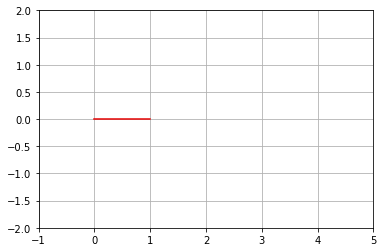

In [61]:
#animate model --> will be able to see what model is doing by viewing in with HTML
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1)
def plot_block(i,model,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,5])
    ax.set_ylim([-2,2])
    
    #plot mass
    m1topx = model.X0.value   #initial position of mass
    m1bottomx = m1topx + model.x1[i].value
    ax.plot([m1bottomx,0],[m1topx,0],color = 'xkcd:red')
    ax.grid(True)
    
update = lambda i: plot_block(i,model,ax1)      #lambdify just used to calculate the numerical values fast

animate = ani.FuncAnimation(fig1,update,range(1,Nodes),interval = 50, repeat = True)

#animate.save('show_me_the_money.gif', writer = 'ffmpeg')

HTML(animate.to_html5_video())

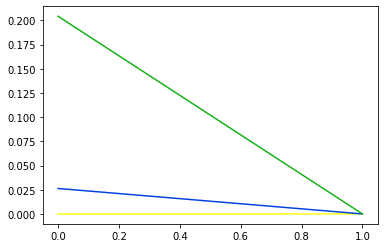

In [62]:
from timeit import timeit

fig2,ax2 = plt.subplots(1,1)
def forces(j,model,ax):
    ax.clear()
    
    #Plot applied force
    force = model.Force[j].value
    #time one execution
   #time = %time np.dot(force,j)
   #Totaltime = 0
   #Totaltime += time
    ax.plot([force,0], color = 'xkcd:yellow')
    
    # plot contraint extention force
    ext_force = model.CF_ext[j].value
    ax.plot([ext_force,0], color = 'xkcd:blue')

    # plot constraint retraction force
    rtn_force = model.CF_rtn[j].value
    ax.plot([rtn_force,0], color = 'xkcd:green')

update1 = lambda j: forces(j,model,ax2)
animate1 = ani.FuncAnimation(fig2,update1,range(1,Nodes),interval = 50, repeat = True)
HTML(animate1.to_html5_video())